In [1]:
%matplotlib inline

In [2]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV, PredefinedSplit
from sklearn.feature_extraction import DictVectorizer
from matplotlib import pyplot as plt
from scipy.stats import uniform, randint

In [3]:
# path to project directory
path = Path('./')

In [149]:
# read in training dataset
# created using fpl_data_clean notebook
train_df = pd.read_csv(path/'data/train.csv', index_col=0, dtype={'season':str})

In [61]:
train_df.head()

,player,gw,position,minutes,team,opponent_team,relative_market_value_team,relative_market_value_opponent_team,was_home,total_points,season,play_proba
0,Aaron_Cresswell,1,2,0,West Ham United,Chelsea,0.895471,2.243698,False,0,1617,NaN
1,Aaron_Lennon,1,3,15,Everton,Tottenham Hotspur,1.057509,1.433690,True,1,1617,NaN
2,Aaron_Ramsey,1,3,60,Arsenal,Liverpool,1.944129,1.465860,True,2,1617,NaN
3,Abdoulaye_Doucouré,1,3,0,Watford,Southampton,0.704200,0.796805,False,0,1617,NaN
4,Abdul Rahman_Baba,1,2,0,Chelsea,West Ham United,2.243698,0.895471,True,0,1617,NaN


In [152]:
train_df[(train_df['team'] == 'Cardiff City') & (train_df['season'] == '1819') & (train_df['gw'] == 1)]

,player,gw,position,minutes,team,opponent_team,relative_market_value_team,relative_market_value_opponent_team,was_home,total_points,season,play_proba
46173,Alex_Smithies,1,1,0,Cardiff City,Bournemouth,0.18389,0.418108,False,0,1819,NaN
46194,Anthony_Pilkington,1,3,0,Cardiff City,Bournemouth,0.18389,0.418108,False,0,1819,NaN
46197,Aron_Gunnarsson,1,3,0,Cardiff City,Bournemouth,0.18389,0.418108,False,0,1819,NaN
46200,Ashley Darel Jazz_Richards,1,2,0,Cardiff City,Bournemouth,0.18389,0.418108,False,0,1819,NaN
46224,Bobby_Reid,1,4,87,Cardiff City,Bournemouth,0.18389,0.418108,False,2,1819,NaN
46228,Bruno_Ecuele Manga,1,2,90,Cardiff City,Bournemouth,0.18389,0.418108,False,1,1819,NaN
46232,Callum_Paterson,1,3,62,Cardiff City,Bournemouth,0.18389,0.418108,False,2,1819,NaN
46272,Danny_Ward_2,1,3,28,Cardiff City,Bournemouth,0.18389,0.418108,False,1,1819,NaN
46278,David Junior_Hoilett,1,3,90,Cardiff City,Bournemouth,0.18389,0.418108,False,2,1819,NaN
46333,Gary_Madine,1,4,2,Cardiff City,Bournemouth,0.18389,0.418108,False,1,1819,NaN


In [71]:
# player level lag features
def gen_lag_features(df, features, lags):
    # need minutes for per game stats, add to front of list
    features.insert(0, 'minutes')

    # calculate totals for each lag period
    for feature in features:
        for lag in lags:
            feature_name = str(feature) + '_last_' + str(lag)
            
            if lag == 'all':
                df[feature_name] = df.groupby(['player'])[feature].apply(lambda x: x.cumsum() - x)
            else: 
                df[feature_name] =df.groupby(['player'])[feature].apply(lambda x: x.rolling(min_periods=1, 
                                                                                            window=lag+1).sum() - x)
            if feature != 'minutes':
                minute_name = 'minutes_last_' + str(lag)
                pg_feature_name = str(feature) + '_pg_last_' + str(lag)
                
                df[pg_feature_name] = 90 * df[feature_name] / df[minute_name] 
                df[pg_feature_name] = df[pg_feature_name].fillna(0)


In [131]:
team_points = train_df.groupby(['team', 
                                'season', 
                                'gw',
                                'opponent_team'])['total_points'].apply(lambda x: x.sum()).rename('total_points_team')

train_df = train_df.merge(team_points, on=['team', 'season', 'gw'], how='left')

In [135]:
#team_points[
team_points.reset_index()[team_points.reset_index()['team'] == 'Cardiff City']
#]#.groupby(['team']).apply(lambda x: x.cumsum() - x).tail(50)

,team,season,gw,opponent_team,total_points_team
634,Cardiff City,1819,1,Bournemouth,23
635,Cardiff City,1819,1,Wolverhampton Wanderers,1
636,Cardiff City,1819,2,Newcastle United,60
637,Cardiff City,1819,2,Southampton,1
638,Cardiff City,1819,3,Bournemouth,0
639,Cardiff City,1819,3,Huddersfield Town,50
640,Cardiff City,1819,4,Arsenal,34
641,Cardiff City,1819,4,Huddersfield Town,1
642,Cardiff City,1819,5,Chelsea,23
643,Cardiff City,1819,5,West Ham United,1


In [133]:
team_points.groupby(['team']).apply(lambda x: x.count())

team
Arsenal                     157
Aston Villa                  19
Bournemouth                 157
Brighton and Hove Albion    119
Burnley                     182
Cardiff City                 60
Chelsea                     244
Crystal Palace              202
Everton                     239
Fulham                       38
Huddersfield Town            97
Hull City                    83
Leicester City              133
Liverpool                   156
Manchester City             133
Manchester United           157
Middlesbrough                81
Newcastle United            145
Norwich                      19
Sheffield United             19
Southampton                 133
Stoke City                  103
Sunderland                   63
Swansea City                146
Tottenham Hotspur           136
Watford                     157
West Bromwich Albion        152
West Ham United             175
Wolverhampton Wanderers      57
Name: total_points_team, dtype: int64

In [76]:
train_df.head(20)

,player,gw,position,minutes,team,opponent_team,relative_market_value_team,relative_market_value_opponent_team,was_home,total_points,season,play_proba,total_points_team
0,Aaron_Cresswell,1,2,0,West Ham United,Chelsea,0.895471,2.243698,False,0,1617,NaN,34
1,Aaron_Lennon,1,3,15,Everton,Tottenham Hotspur,1.057509,1.433690,True,1,1617,NaN,42
2,Aaron_Ramsey,1,3,60,Arsenal,Liverpool,1.944129,1.465860,True,2,1617,NaN,29
3,Abdoulaye_Doucouré,1,3,0,Watford,Southampton,0.704200,0.796805,False,0,1617,NaN,35
4,Abdul Rahman_Baba,1,2,0,Chelsea,West Ham United,2.243698,0.895471,True,0,1617,NaN,39
5,Abel_Hernández,1,4,90,Hull City,Leicester City,0.494447,0.650832,True,5,1617,NaN,26
6,Adama_Diomande,1,4,90,Hull City,Leicester City,0.494447,0.650832,True,8,1617,NaN,26
7,Adam_Clayton,1,3,90,Middlesbrough,Stoke City,0.452793,0.718705,True,2,1617,NaN,38
8,Adam_Federici,1,1,0,Bournemouth,Manchester United,0.384921,1.983179,True,0,1617,NaN,30
9,Adam_Forshaw,1,3,69,Middlesbrough,Stoke City,0.452793,0.718705,True,1,1617,NaN,38


In [77]:
train_df.to_csv(path/'checks.csv')

In [22]:
gen_lag_features(train_df, ['total_points'], ['all', 1, 2, 3, 4, 5, 10, 20])

In [23]:
train_df.head()

,player,gw,position,minutes,team,opponent_team,relative_market_value_team,relative_market_value_opponent_team,was_home,total_points,...,total_points_last_3,total_points_pg_last_3,total_points_last_4,total_points_pg_last_4,total_points_last_5,total_points_pg_last_5,total_points_last_10,total_points_pg_last_10,total_points_last_20,total_points_pg_last_20
0,Aaron_Cresswell,1,2,0,West Ham United,Chelsea,0.895471,2.243698,False,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Aaron_Lennon,1,3,15,Everton,Tottenham Hotspur,1.057509,1.433690,True,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Aaron_Ramsey,1,3,60,Arsenal,Liverpool,1.944129,1.465860,True,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Abdoulaye_Doucouré,1,3,0,Watford,Southampton,0.704200,0.796805,False,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Abdul Rahman_Baba,1,2,0,Chelsea,West Ham United,2.243698,0.895471,True,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
train_df[train_df['player'] == 'Mohamed_Salah'].head(10)

,player,gw,position,minutes,team,opponent_team,relative_market_value_team,relative_market_value_opponent_team,was_home,total_points,...,total_points_last_3,total_points_pg_last_3,total_points_last_4,total_points_pg_last_4,total_points_last_5,total_points_pg_last_5,total_points_last_10,total_points_pg_last_10,total_points_last_20,total_points_pg_last_20
24036,Mohamed_Salah,1,3,85,Liverpool,Watford,1.619155,0.547242,False,11,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
24551,Mohamed_Salah,2,3,29,Liverpool,Crystal Palace,1.619155,0.635984,True,1,...,11.0,11.647059,11.0,11.647059,11.0,11.647059,11.0,11.647059,11.0,11.647059
25076,Mohamed_Salah,3,3,90,Liverpool,Arsenal,1.619155,2.073500,True,11,...,12.0,9.473684,12.0,9.473684,12.0,9.473684,12.0,9.473684,12.0,9.473684
25614,Mohamed_Salah,4,3,45,Liverpool,Manchester City,1.619155,2.016093,False,1,...,23.0,10.147059,23.0,10.147059,23.0,10.147059,23.0,10.147059,23.0,10.147059
26160,Mohamed_Salah,5,3,90,Liverpool,Burnley,1.619155,0.316798,True,10,...,13.0,7.134146,24.0,8.674699,24.0,8.674699,24.0,8.674699,24.0,8.674699
26708,Mohamed_Salah,6,3,90,Liverpool,Leicester City,1.619155,0.824624,False,7,...,22.0,8.800000,23.0,8.149606,34.0,9.026549,34.0,9.026549,34.0,9.026549
27261,Mohamed_Salah,7,3,83,Liverpool,Newcastle United,1.619155,0.547176,False,2,...,18.0,7.200000,29.0,8.285714,30.0,7.848837,41.0,8.601399,41.0,8.601399
27817,Mohamed_Salah,8,3,77,Liverpool,Manchester United,1.619155,2.110135,True,3,...,19.0,6.501901,20.0,5.844156,31.0,7.010050,43.0,7.558594,43.0,7.558594
28376,Mohamed_Salah,9,3,90,Liverpool,Tottenham Hotspur,1.619155,1.751141,False,7,...,12.0,4.320000,22.0,5.823529,23.0,5.376623,46.0,7.028862,46.0,7.028862
28939,Mohamed_Salah,10,3,80,Liverpool,Huddersfield Town,1.619155,0.210654,True,4,...,12.0,4.320000,19.0,5.029412,29.0,6.069767,53.0,7.025037,53.0,7.025037


In [25]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78390 entries, 0 to 78389
Data columns (total 36 columns):
player                                 78390 non-null object
gw                                     78390 non-null int64
position                               78390 non-null int64
minutes                                78390 non-null int64
team                                   78390 non-null object
opponent_team                          78390 non-null object
relative_market_value_team             78390 non-null float64
relative_market_value_opponent_team    78390 non-null float64
was_home                               78390 non-null bool
total_points                           78390 non-null int64
season                                 78390 non-null object
play_proba                             10385 non-null float64
minutes_last_all                       78390 non-null int64
minutes_last_1                         78390 non-null float64
minutes_last_2                         7

In [30]:
# set categorical, continuous variables
# and dependent variable
cat_vars = ['season', 'position', 'team', 'opponent_team', 'was_home']
cont_vars = ['gw', 'minutes', 'relative_market_value_team', 
             'relative_market_value_opponent_team', 
#              'minutes_last_all', 
#              'minutes_last_1', 
#              'minutes_last_2',
#              'minutes_last_3',
#              'minutes_last_4',
#              'minutes_last_5',
#              'minutes_last_10',
#              'minutes_last_20',
#              'total_points_last_all',
#              'total_points_last_1',
#              'total_points_last_2',
#              'total_points_last_3',
#              'total_points_last_4',
#              'total_points_last_5',
#              'total_points_last_10',
#              'total_points_last_20',
             'total_points_pg_last_all',
             'total_points_pg_last_1',
             'total_points_pg_last_2',
             'total_points_pg_last_3',
             'total_points_pg_last_4',
             'total_points_pg_last_5',
             'total_points_pg_last_10']
dep_var = 'total_points'

In [31]:
X, y = train_df[cat_vars + cont_vars].copy(), train_df[dep_var].copy()

In [32]:
# find validation cut point - index for 18-19 season second half (gw 19)
#valid_start = train_df[(train_df['gw'] > 18) & (train_df['season'] == '1819')].index.min()
# or take validation as same as current prediction set
valid_start = train_df[(train_df['season'] == '1819') & (train_df['gw'] == 20)].index.min()
valid_end = train_df[(train_df['season'] == '1920') & (train_df['gw'] == 1)].index.min()

In [33]:
X['position'] = X['position'].apply(str)

In [34]:
#X['season'] = X['season'].replace({'1617':1, '1718':2, '1819':3, '1920':4})
enc = LabelEncoder()
X['season'] = enc.fit_transform(X['season'])

In [35]:
X_dict = X.to_dict("records")

# Create the DictVectorizer object: dv
dv = DictVectorizer(sparse=False, separator='_')

# Apply dv on df: df_encoded
X_encoded = dv.fit_transform(X_dict)

In [36]:
X_df = pd.DataFrame(X_encoded, columns=dv.feature_names_)
X_df.head()

,gw,minutes,opponent_team_Arsenal,opponent_team_Aston Villa,opponent_team_Bournemouth,opponent_team_Brighton and Hove Albion,opponent_team_Burnley,opponent_team_Cardiff City,opponent_team_Chelsea,opponent_team_Crystal Palace,...,team_West Ham United,team_Wolverhampton Wanderers,total_points_pg_last_1,total_points_pg_last_10,total_points_pg_last_2,total_points_pg_last_3,total_points_pg_last_4,total_points_pg_last_5,total_points_pg_last_all,was_home
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.0,60.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [37]:
X_df.columns

Index(['gw', 'minutes', 'opponent_team_Arsenal', 'opponent_team_Aston Villa',
       'opponent_team_Bournemouth', 'opponent_team_Brighton and Hove Albion',
       'opponent_team_Burnley', 'opponent_team_Cardiff City',
       'opponent_team_Chelsea', 'opponent_team_Crystal Palace',
       'opponent_team_Everton', 'opponent_team_Fulham',
       'opponent_team_Huddersfield Town', 'opponent_team_Hull City',
       'opponent_team_Leicester City', 'opponent_team_Liverpool',
       'opponent_team_Manchester City', 'opponent_team_Manchester United',
       'opponent_team_Middlesbrough', 'opponent_team_Newcastle United',
       'opponent_team_Norwich', 'opponent_team_Sheffield United',
       'opponent_team_Southampton', 'opponent_team_Stoke City',
       'opponent_team_Sunderland', 'opponent_team_Swansea City',
       'opponent_team_Tottenham Hotspur', 'opponent_team_Watford',
       'opponent_team_West Bromwich Albion', 'opponent_team_West Ham United',
       'opponent_team_Wolverhampton Wand

In [148]:
X_train = X_df[0:valid_end]
y_train = y[0:valid_end]

In [149]:
test_fold = np.repeat([-1, 0], [valid_start, valid_end - valid_start])

In [150]:
len(test_fold)

67936

In [151]:
ps = PredefinedSplit(test_fold)

In [152]:
# Create the parameter grid: gbm_param_grid 
gbm_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [2, 3, 5],
    #'colsample_bytree': [0.1, 0.5, 0.8, 1],
    'learning_rate': [0.1]
}

In [153]:
params = {#"colsample_bytree": uniform(0.7, 0.3),
          "gamma": uniform(0, 0.5),
          "learning_rate": uniform(0.003, 0.3), # default 0.1 
          "max_depth": randint(2, 6), # default 3
          "n_estimators": randint(25, 200), # default 100
          "subsample": uniform(0.6, 0.4)}

In [154]:
# Instantiate the regressor: gbm
gbm = xgb.XGBRegressor(objective="reg:squarederror")

In [155]:
# Perform random search: grid_mse
randomized_mse = RandomizedSearchCV(estimator=gbm, 
                                    param_distributions=params, 
                                    scoring="neg_mean_squared_error", 
                                    n_iter=25, 
                                    cv=ps, 
                                    verbose=1)

In [156]:
xgb.__version__

'0.90'

In [157]:
# Fit randomized_mse to the data
randomized_mse.fit(X_train, y_train)

Fitting 1 folds for each of 25 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a futur

RandomizedSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
          error_score='raise-deprecating',
          estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:squarederror',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=None, subsample=1, verbosity=1),
          fit_params=None, iid='warn', n_iter=25, n_jobs=None,
          param_distributions={'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f773c6acd68>, 'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f773c6ac8d0>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f773c6bc5c0>, 'n_estimators': <scipy.stats._distn_infrastructure.rv_fr

In [158]:
# Print the best parameters and lowest RMSE
print("Best parameters found: ", randomized_mse.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(randomized_mse.best_score_)))

Best parameters found:  {'gamma': 0.35230664269238343, 'learning_rate': 0.03214867523376804, 'max_depth': 5, 'n_estimators': 197, 'subsample': 0.7554749548877047}
Lowest RMSE found:  1.8450282939546638


In [38]:
# training and validation sets
X_train = X_df[0:valid_start]
y_train = y[0:valid_start]
X_test = X_df[valid_start:valid_end]
y_test = y[valid_start:valid_end]

In [39]:
#xg_reg = xgb.XGBRegressor(n_estimators=75, max_depth=5, learning_rate=0.1)

xg_reg = xgb.XGBRegressor(gamma=0.047479, learning_rate=0.0828905304021426, max_depth=5, n_estimators=75, subsample=0.6862963240045978)

xg_reg.fit(X_train, y_train)

preds = xg_reg.predict(X_test)

rmse = np.sqrt(mean_squared_error(preds, y_test))
print("RMSE: %f" % (rmse))

C:\Users\paul.solomon\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\paul.solomon\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[11:21:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE: 1.845877


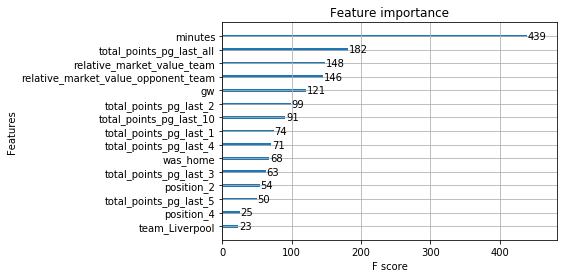

In [40]:
#plt.style.use('ggplot')
xgb.plot_importance(xg_reg, max_num_features=15)
plt.show()

In [59]:
max(preds)

8.015433

In [22]:
results = X_test.merge(y_test.to_frame(), left_index=True, right_index=True)
results['preds'] = preds
results

,gw,minutes,opponent_team_Arsenal,opponent_team_Aston Villa,opponent_team_Bournemouth,opponent_team_Brighton and Hove Albion,opponent_team_Burnley,opponent_team_Cardiff City,opponent_team_Chelsea,opponent_team_Crystal Palace,...,team_Sunderland,team_Swansea City,team_Tottenham Hotspur,team_Watford,team_West Bromwich Albion,team_West Ham United,team_Wolverhampton Wanderers,was_home,total_points,preds
56539,20.0,90.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,3.174152
56540,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0.029738
56541,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.027991
56542,20.0,90.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,2.892542
56543,20.0,90.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2,2.021116
56544,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0.018358
56545,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.027991
56546,20.0,36.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,7,1.363438
56547,20.0,45.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1,1.608021
56548,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,0.005136
